In [1]:
!pip install ISLP

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 3.6/3.6 MB 90.6 MB/s  0:00:00
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 9.6/9.6 MB 100.3 MB/s  0:00:00
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 4.0/4.0 MB 92.2 MB/s  0:00:00
   ---------------------------------------- 0.0/832.4 kB ? eta -:--:--
   ---------------------------------------- 832.4/832.4 kB 45.1 MB/s  0:00:00
   ---------------------------------------- 0.0/983.2 kB ? eta -:--:--
   ---------------------------------------- 983.2/983.2 kB 49.8 MB/s  0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4138 sha256=95589e52c8ce12fd4dab135525217d887cde06dabc819488fb3000dc5908412e
  Sto

  DEPRECATION: Building 'autograd-gamma' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autograd-gamma'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Assignment 1: Bag of Words, Naive Bayes, Support Vector Machines, Decision/Regression Trees

Deadline: Sunday, October 26th, 2025, 23:59

Environment: Python, numpy, pandas, matplotlib, scikit-learn, ntlk, ISLP.

---

## Part A: Binary Classification on Text Data

In this part, you will implement several machine learning techniques from class to perform classification on text data. Throughout the problem, we will be working with the **NLP with Disaster Tweets** Kaggle competition data; the task is to predict whether or not a tweet is about a real disaster.


In [2]:
# Import basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import nltk
import string
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

### 1. **Data Loading and Splitting**
  Load the dataset; its path in the repository is `data/disaster_tweets.csv`.

  * What percentage of the data are of real disasters, and what percentage is not? The description of each column is explained in the `README.md` contained in the `data` folder.
  * Split the data into 70% training and 30% testing.

In [5]:
# Load dataset
np.random.seed(20)
df = pd.read_csv("../data/disaster_tweets.csv")

In [6]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (7613, 5)
Columns: ['id', 'keyword', 'location', 'text', 'target']

First few rows:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [7]:
# Calculate class distribution
real_disasters = df['target'].sum()
not_disasters = len(df) - real_disasters
real_percentage = (real_disasters / len(df)) * 100
not_percentage = (not_disasters / len(df)) * 100

print(f"\nClass distribution:")
print(f"Real disasters: {real_disasters} ({real_percentage:.2f}%)")
print(f"Not disasters: {not_disasters} ({not_percentage:.2f}%)")


Class distribution:
Real disasters: 3271 (42.97%)
Not disasters: 4342 (57.03%)


In [8]:
# Split data into 70% training and 30% testing

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['target'], test_size=0.3, random_state=20, stratify=df['target']
)

print(f"\nX_train size: {len(X_train)}")
print(f"X_test size: {len(X_test)}")

print(f"\ny_train size: {len(y_train)}")
print(f"y_test size: {len(y_test)}")


X_train size: 5329
X_test size: 2284

y_train size: 5329
y_test size: 2284


### 2. **Data Pre-processing**
  Since the data consists of tweets, they may contain significant amounts of noise and unprocessed content. You **may or may not** want to do one or all of the following. Explain the reasons for each of your decisions (why/why not).

  * Convert all the words to lowercase.
  * Lemmatize/stem all the words (you can use `nltk` as we did in the practical session).
  * Strip punctuation.
  * Strip stop words.
  * Strip "@" and urls.
  * You may come up with your own extra procedures (explain them if you do).



**Decisions:**

- Convert all the words to lowercase. -> Yes, because we need to standardize the text
- Lemmatize/stem all the words (you can use nltk as we did in the practical session). -> Yes, because it's easier to generalize with the base form of each word.

- Strip punctuation. -> Yes, because punctuation doesn't add any meaning.

- Strip stop words. -> Yes, because stop words usually don't give useful information.

- Strip "@" and urls. -> Yes, because "@" could be a mention or an email address and it doesn't give useful information. Same for urls.

*Extras:*

- *Hasthags -> Keeping the words, byt removing the # symbol.*

- *Numbers -> Removing the number because they don't give useful information.*







In [9]:
# Preprocess function

def preprocess_text(text,
                   lowercase=True,
                   hashtag_symbol=True,
                   remove_numbers=True,
                   strip_mentions_urls=True,
                   lemmatize=True,
                   strip_punctuation=True,
                   strip_stopwords=True,
                   ):
    """
    Preprocess tweet text with various cleaning options.

    Parameters:
    -----------
    text : str
        Input text to preprocess
    lowercase : bool
        Convert to lowercase
    lemmatize : bool
        Apply lemmatization
    strip_punctuation : bool
        Remove punctuation
    strip_stopwords : bool
        Remove stopwords
    strip_mentions_urls : bool
        Remove @ mentions and URLs
    """
    # Convert to lowercase
    if lowercase:
        text = text.lower()

    # Strip @ mentions and URLs
    if strip_mentions_urls:
        # Remove URLs
        text = re.sub(r'http\S+|www.\S+', '', text)
        # Remove @ mentions
        text = re.sub(r'@\w+', '', text)

    # Remove # symbol
    if hashtag_symbol:
        text = re.sub(r'#(\w+)', r'\1', text)

    # Remove numbers
    if remove_numbers:
        text = re.sub(r'\d+', '', text)

    # Remove punctuation
    if strip_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords
    if strip_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words]

    # Lemmatize
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]

    return ' '.join(words)

In [10]:
# Preprocess
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

print(f"Sample Original Tweet: {X_train.iloc[0]}")
print(f"Sample Processed Tweet: {X_train_processed.iloc[0]}")

Sample Original Tweet: 5 Rejected Mortal Kombat Fatalities: Mortal Kombat has stretched the boundaries of itsÛ_ http://t.co/igZ7v24GE9 http://t.co/M75DNf2xyg
Sample Processed Tweet: rejected mortal kombat fatality mortal kombat stretched boundary itsû


In [11]:
print(f"\nX_train_processed size: {len(X_train_processed)}")
print(f"X_test_processed size: {len(X_test_processed)}")

print(f"\ny_train size: {len(y_train)}")
print(f"y_test size: {len(y_test)}")


X_train_processed size: 5329
X_test_processed size: 2284

y_train size: 5329
y_test size: 2284


### 3. **Bag of Words Model**
  Your next task is to extract features in order to represent each tweet using the binary "bag of words" model, as discussed in the practical session. The idea is to build a vocabulary of the words appearing in the dataset, and represent each tweet by a feature vector $x$ whose length is the same as the size of the vocabulary, where $x_i=1$ if the $i$'th vocabulary word appear in that tweet, and $x_i=0$ otherwise. Using `CountVectorizer`:
  
  * Set the option `binary=True` to ensure the feature vectors are binary.
  * Pick a threshold $M$ (using option `min_df=M`) such that only words that appear in at least $M$ are included in the vocabulary.
  * Make sure you fit `CountVectorizer` only on your training set, and use the same instance to process both training and testing observations.
  * **Note**: Only construct feature vectors using the text in the `text` column. Ignore `keyword` and `location` for now.
  * Report the total number of words in your vocabulary.



In [12]:
# Analyze using vectorizer
vectorizer = CountVectorizer(binary=True)
X_train_bow= vectorizer.fit_transform(X_train_processed)
X_test_bow = vectorizer.transform(X_test_processed)
feature_names = vectorizer.get_feature_names_out()

In [13]:
X_train_bow.shape

(5329, 10987)

In [14]:
feature_names

array(['aa', 'aaaa', 'aaaaaaallll', ..., 'ûónegligence', 'ûótech', 'ûówe'],
      shape=(10987,), dtype=object)

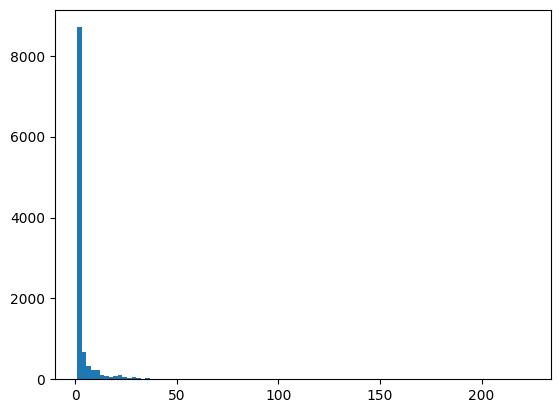

In [15]:
plt.hist(X_train_bow.toarray().sum(0), bins = 100)
plt.show()

In [16]:
np.quantile(X_train_bow.toarray().sum(0), [.1, .25, .5, .75, .9])

array([1., 1., 1., 3., 9.])

In [17]:
# Filter out the ones that don't tend to appear. We have chosen just M=2 because we have a small data and we want the longest train data.

M = 2
vectorizer = CountVectorizer(binary=True, min_df=M)
X_train_bow = vectorizer.fit_transform(X_train_processed)
X_test_bow = vectorizer.transform(X_test_processed)
feature_names = vectorizer.get_feature_names_out()

In [18]:
X_train_bow.shape

(5329, 4491)

In [19]:
feature_names

array(['aa', 'ab', 'aba', ..., 'ûïyou', 'ûò', 'ûó'],
      shape=(4491,), dtype=object)

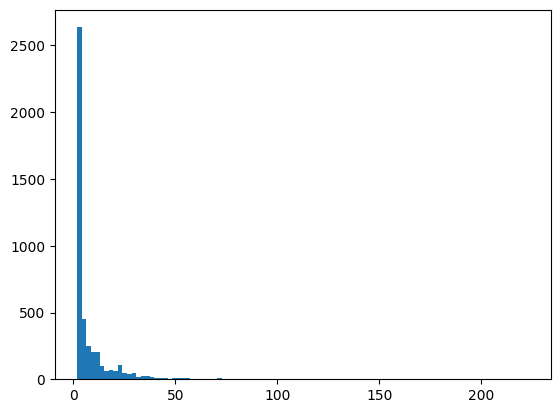

In [20]:
plt.hist(X_train_bow.toarray().sum(0), bins=100)
plt.show()

In [21]:
# Summarize

vocabulary_size = len(feature_names)
print(f"Vocabulary size (words appearing in at least {M} tweets): {vocabulary_size}")
print(f"Training data shape after BoW: {X_train_bow.shape}")
print(f"Testing data shape after BoW: {X_test_bow.shape}")

Vocabulary size (words appearing in at least 2 tweets): 4491
Training data shape after BoW: (5329, 4491)
Testing data shape after BoW: (2284, 4491)


### 4. **Logistic Regression**
  We will train and evaluate several logistic regression models. We will specifically be using the F1 score for evaluation.

  * Train a logistic regression model without regularization terms. By default, `sklearn` uses L2 regularization, but you can turn it off using the `penalty` parameter. Report the F1 score for the training and testing set. Comment whether you observe any issues with overfitting or underfitting.
  * Train a logistic regression model with L1 regularization, making sure to use *some* procedure to pick the optimal penalty parameter. Report the performance of the final model and comment.
  * Same as the previous point, but now with L2 regularization.
  * Which one of the three classifiers performed best on your training and testing set? Did you observe any overfitting and did regularization help reduce it? Support your answers with the classifier performance you got.
  * Inspect the weight vector of the classifier with L1 regularization. What are the most important words for deciding whether a tweet is about a real disaster or not?



In [22]:
# Logistic regression model without regularization

lr_no_reg = LogisticRegression()
lr_no_reg.fit(X_train_bow, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [23]:
train_pred_no_reg = lr_no_reg.predict(X_train_bow)
test_pred_no_reg = lr_no_reg.predict(X_test_bow)

train_f1_no_reg = f1_score(y_train, train_pred_no_reg)
test_f1_no_reg = f1_score(y_test, test_pred_no_reg)

print(f"Training F1 score (Without regularization): {train_f1_no_reg:.4f}")
print(f"Testing F1 score (Without regularization): {test_f1_no_reg:.4f}")
print(f"Overfitting observed (Without regularization): {train_f1_no_reg - test_f1_no_reg > 0.05} ({(train_f1_no_reg - test_f1_no_reg):.4f})")

Training F1 score (Without regularization): 0.9117
Testing F1 score (Without regularization): 0.7448
Overfitting observed (Without regularization): True (0.1668)


We observe overfitting issues (0.1668).

In [24]:
# Logistic Regression with L1 regularization

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
grid_l1 = GridSearchCV(lr_l1, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_l1.fit(X_train_bow, y_train)

,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [25]:
print(f"Best C parameter: {grid_l1.best_params_['C']}")

Best C parameter: 1


In [26]:
train_pred_l1 = grid_l1.predict(X_train_bow)
test_pred_l1 = grid_l1.predict(X_test_bow)
train_f1_l1 = f1_score(y_train, train_pred_l1)
test_f1_l1 = f1_score(y_test, test_pred_l1)


print(f"Training F1 score (L1 regularization): {train_f1_l1:.4f}")
print(f"Testing F1 score (L1 regularization): {test_f1_l1:.4f}")
print(f"Overfitting observed (L1 regularization): {train_f1_l1 - test_f1_l1 > 0.05} ({(train_f1_l1 - test_f1_l1):.4f})")

print(f"\nTraining F1 score (L1 regularization - Without regularization): {train_f1_l1 - train_f1_no_reg:.4f}")
print(f"Testing F1 score (L1 regularization - Without regularization): {test_f1_l1 - test_f1_no_reg:.4f}")

Training F1 score (L1 regularization): 0.8554
Testing F1 score (L1 regularization): 0.7367
Overfitting observed (L1 regularization): True (0.1188)

Training F1 score (L1 regularization - Without regularization): -0.0562
Testing F1 score (L1 regularization - Without regularization): -0.0082


We observe overfitting issues (0.1188) but less than without regularization (0.1668).

In [27]:
# Logistic Regression with L2 regularization

lr_l2 = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
grid_l2 = GridSearchCV(lr_l2, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_l2.fit(X_train_bow, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [28]:
print(f"Best C parameter: {grid_l2.best_params_['C']}")

Best C parameter: 1


In [29]:
train_pred_l2 = grid_l2.predict(X_train_bow)
test_pred_l2 = grid_l2.predict(X_test_bow)

train_f1_l2 = f1_score(y_train, train_pred_l2)
test_f1_l2 = f1_score(y_test, test_pred_l2)

print(f"Training F1 score (L2 regularization): {train_f1_l2:.4f}")
print(f"Testing F1 score (L2 regularization): {test_f1_l2:.4f}")
print(f"Overfitting observed (L2 regularization): {train_f1_l2 - test_f1_l2 > 0.05} ({(train_f1_l2 - test_f1_l2):.4f})")

print(f"\nTraining F1 score (L2 regularization - Without regularization): {train_f1_l2 - train_f1_no_reg:.4f}")
print(f"Testing F1 score (L2 regularization - Without regularization): {test_f1_l2 - test_f1_no_reg:.4f}")

Training F1 score (L2 regularization): 0.9117
Testing F1 score (L2 regularization): 0.7448
Overfitting observed (L2 regularization): True (0.1668)

Training F1 score (L2 regularization - Without regularization): 0.0000
Testing F1 score (L2 regularization - Without regularization): 0.0000


We observe overfitting issues (0.1668) same as without regularization (0.1668).

Comments:

| Classifier| F1 for training | F1 for testing | Overfitting Observed |
|---------------------------|------------------|-----------|------------------------|
| Without regularization | 0.9117 | 0.7448 | Yes (0.1668) |
| L1 regularization | 0.8554 | 0.7367 | Yes, but reduced (0.1188)|
| L2 regularizationn | 0.9117 | 0.7448 | Yes, same as without regularization (0.1668) |

The classifier without regularization and the L2 regularization model performed best on the training set with an F1 score of 0.9117 and also performed best on the testing set with an F1 score of 0.7448.

We observed overfitting in all three classifiers, but the L1 regularization model reduces it with a smaller difference between training and testing of 0.1188.

**Conclusion**: While the unregularized and L2 models performed best in terms of raw scores, the L1 regularized model offered a better balance between training and testing performance, making it the most generalizable among the three.

In [30]:
feature_names = vectorizer.get_feature_names_out()
coef = grid_l1.best_estimator_.coef_[0]
top_positive_idx = np.argsort(coef)[-10:]
top_negative_idx = np.argsort(coef)[:10]
print("\nTop words for REAL disasters:")
for idx in top_positive_idx[::-1]:
    print(f"  {feature_names[idx]:15} (weight: {coef[idx]:.3f})")

print("\nTop words for NOT disasters:")
for idx in top_negative_idx:
    print(f"  {feature_names[idx]:15} (weight: {coef[idx]:.3f})")


Top words for REAL disasters:
  typhoon         (weight: 3.686)
  migrant         (weight: 3.558)
  hiroshima       (weight: 3.325)
  mh              (weight: 3.235)
  earthquake      (weight: 3.176)
  derailment      (weight: 2.916)
  incident        (weight: 2.755)
  distance        (weight: 2.752)
  spill           (weight: 2.650)
  debris          (weight: 2.624)

Top words for NOT disasters:
  ebay            (weight: -2.738)
  character       (weight: -2.090)
  join            (weight: -2.068)
  hurt            (weight: -1.967)
  ice             (weight: -1.836)
  super           (weight: -1.804)
  shes            (weight: -1.777)
  write           (weight: -1.693)
  step            (weight: -1.650)
  welcome         (weight: -1.649)


### 5. **Bernoulli Naive Bayes**
  Just like point 4, but now using the Bernoulli Naive Bayes algorithm for prediction.

  * Write the necessary funtions to perform the Bernoulli Naive Bayes procedure, like we did in the practical session. Use Laplace smoothing with $\alpha=1$.
  * Report the F1 score for the training and testing sets. Comment.



In [31]:
class BernoulliNaiveBayes:
    """
    Bernoulli Naive Bayes implementation with Laplace smoothing.
    """
    def __init__(self, alpha=1.0):
        """
        Parameters:
        -----------
        alpha : float
            Laplace smoothing parameter
        """
        self.alpha = alpha
        self.class_priors = None
        self.feature_probs = None
        self.classes = None

    def fit(self, X, y):
        """
        Fit the Bernoulli Naive Bayes model.

        Parameters:
        -----------
        X : sparse matrix or array-like
            Training features (binary)
        y : array-like
            Training labels
        """
        # Convert to dense if sparse
        if hasattr(X, 'toarray'):
            X = X.toarray()

        self.classes = np.unique(y)
        n_samples, n_features = X.shape
        n_classes = len(self.classes)

        # Calculate class priors
        self.class_priors = np.zeros(n_classes)
        self.feature_probs = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[idx] = X_c.shape[0] / n_samples

            # Calculate feature probabilities with Laplace smoothing
            self.feature_probs[idx] = (X_c.sum(axis=0) + self.alpha) / (X_c.shape[0] + 2 * self.alpha)

        return self

    def predict_log_proba(self, X):
        """
        Predict log probabilities for each class.
        """
        if hasattr(X, 'toarray'):
            X = X.toarray()

        n_samples = X.shape[0]
        log_probs = np.zeros((n_samples, len(self.classes)))

        for idx in range(len(self.classes)):
            # Log prior
            log_prior = np.log(self.class_priors[idx])

            # Log likelihood
            log_likelihood = X * np.log(self.feature_probs[idx]) + \
                           (1 - X) * np.log(1 - self.feature_probs[idx])
            log_likelihood = log_likelihood.sum(axis=1)

            log_probs[:, idx] = log_prior + log_likelihood

        return log_probs

    def predict(self, X):
        """
        Predict class labels.
        """
        log_probs = self.predict_log_proba(X)
        return self.classes[np.argmax(log_probs, axis=1)]

In [32]:
bnb = BernoulliNaiveBayes(alpha=1.0)
bnb.fit(X_train_bow, y_train)

train_pred_bnb = bnb.predict(X_train_bow)
test_pred_bnb = bnb.predict(X_test_bow)

train_f1_bnb = f1_score(y_train, train_pred_bnb)
test_f1_bnb = f1_score(y_test, test_pred_bnb)

print(f"Training F1 score: {train_f1_bnb:.4f}")
print(f"Testing F1 score: {test_f1_bnb:.4f}")
print(f"Overfitting observed: {train_f1_bnb - test_f1_bnb > 0.05} ({(train_f1_bnb - test_f1_bnb):.4f})")

Training F1 score: 0.8337
Testing F1 score: 0.7479
Overfitting observed: True (0.0858)


Comments:

The Bernoulli Naive Bayes model generalized better on the test set, with an F1 score of 0.7479 and lower overfitting (0.0858) compared to the logistic models. This demonstrates that regularization can help to reduce overfitting, but Naive Bayes may offer a better balance between accuracy and generalization.


### 6. **N-gram model**
  We will extend what we learned in class. The $N$-gram model uses contiguous sequences of words; e.g., for $N=2$, the text "Alice fell down the rabbit hole" consists creates a vocabulary with the 2-grams ["Alice fell", "fell down", "down the", "the rabbit", "rabbit hole"] **may also** contain the 1-grams ["Alice", "fell", "down", "the", "rabbit", "hole"].

  * Use `CountVectorizer` to create 2-grams. You may set the option `ngram_range=(2,2)` to use only sequences of two words.
  * Again, choose a threshold $M$ too use only 2-grams that appear in at least $M$ tweets. Justify your choice of $M$.
  * Report the total number of 2-grams in your vocabulary.
  * Take 10 2-grams from your vocabulary and print them out.
  * Implement a logistic regression (choose one of any of the specifications, i.e. the type of regularization, if any) and a Bernouli classifier to train on 2-grams (you may reuse code from parts 4 and 5).
  * Report your results on the training and the testing set.
  * Do these results differ significantly from those using the bag of words model? Discuss.

In [33]:
# Create 2-gram features

min_df_2gram = 2

print(f"Using min_df={min_df_2gram} (justified: 2-grams are sparser than unigrams)")

vectorizer_2gram = CountVectorizer(
    binary=True,
    ngram_range=(2, 2),
    min_df=min_df_2gram
)

X_train_2gram = vectorizer_2gram.fit_transform(X_train_processed)
X_test_2gram = vectorizer_2gram.transform(X_test_processed)

vocabulary_size_2gram = len(vectorizer_2gram.get_feature_names_out())
print(f"2-gram vocabulary size: {vocabulary_size_2gram}")

Using min_df=2 (justified: 2-grams are sparser than unigrams)
2-gram vocabulary size: 3491


In [34]:
# Sample 2-grams

sample_2grams = vectorizer_2gram.get_feature_names_out()[:10]
print("\nSample 2-grams from vocabulary:")
for bigram in sample_2grams:
    print(f"  '{bigram}'")


Sample 2-grams from vocabulary:
  'aba woman'
  'abandoned aircraft'
  'abbswinston zionist'
  'abc news'
  'abc online'
  'abcnews obama'
  'ablaze amp'
  'abomination maketh'
  'absolutely demolished'
  'access secret'


In [35]:
# Logistic Regression on 2-grams

lr_2gram = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
lr_2gram.fit(X_train_2gram, y_train)

train_pred_2gram_lr = lr_2gram.predict(X_train_2gram)
test_pred_2gram_lr = lr_2gram.predict(X_test_2gram)

train_f1_2gram_lr = f1_score(y_train, train_pred_2gram_lr)
test_f1_2gram_lr = f1_score(y_test, test_pred_2gram_lr)

print(f"Training F1 score : {train_f1_2gram_lr:.4f}")
print(f"Testing F1 score: {test_f1_2gram_lr:.4f}")
print(f"Overfitting observed: {train_f1_2gram_lr - test_f1_2gram_lr > 0.05} ({(train_f1_2gram_lr - test_f1_2gram_lr):.4f})")

Training F1 score : 0.7286
Testing F1 score: 0.6105
Overfitting observed: True (0.1181)


In [36]:
# Bernoulli Naive Bayes on 2-grams

bnb_2gram = BernoulliNaiveBayes(alpha=1.0)
bnb_2gram.fit(X_train_2gram, y_train)

train_pred_2gram_bnb = bnb_2gram.predict(X_train_2gram)
test_pred_2gram_bnb = bnb_2gram.predict(X_test_2gram)

train_f1_2gram_bnb = f1_score(y_train, train_pred_2gram_bnb)
test_f1_2gram_bnb = f1_score(y_test, test_pred_2gram_bnb)

print(f"Training F1 score: {train_f1_2gram_bnb:.4f}")
print(f"Testing F1 score: {test_f1_2gram_bnb:.4f}")
print(f"Overfitting observed: {train_f1_2gram_bnb - test_f1_2gram_bnb > 0.05} ({(train_f1_2gram_bnb - test_f1_2gram_bnb):.4f})")

Training F1 score: 0.6160
Testing F1 score: 0.5329
Overfitting observed: True (0.0831)


Comments:

Two-gram-based models performed significantly worse than the BoW model in both logistic regression and Bernoulli Naive Bayes. This is because two-grams are more specific and less frequent, resulting in a sparser representation that is less effective for classification. Therefore, there is a significant difference in performance compared to the BoW model, which remains more effective in this context.


## Part B: Support Vector Machine and Overfitting.

We will examine whether a low or high $C$ parameter for the objective function of the SVM algorithm can lead to overfitting.

1. **Generate Data**
  
  * Generate data with two features and two classes, such that the classes are barely linearly separable.



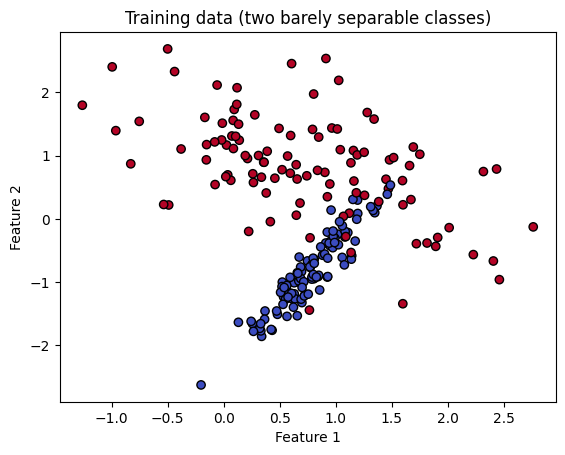

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Generate data with 2 features, 2 classes and noise
X, y = make_classification(
    n_samples=300, n_features=2, n_redundant=0,
    n_informative=2, n_clusters_per_class=1,
    class_sep=0.8, random_state=42
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.title("Training data (two barely separable classes)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()




2. **Test a Variety of C's**

  * Compute the cross-validation error rates for support vector classifiers with a range of $C$ values. How many training observations are misclassified for each value of $C$ considered, and how does this relate to the cross-validation errors obtained?

In [38]:
# Range of values ​​for C
C_values = np.logspace(-3, 2, 10)

train_misclassified = []
cv_errors = []

for C in C_values:
    svm = SVC(C=C, kernel='linear', random_state=42)
    svm.fit(X_train, y_train)

    # Predictions on the training set
    y_pred_train = svm.predict(X_train)

    # Number of misclassified observations in training
    misclassified = np.sum(y_pred_train != y_train)
    train_misclassified.append(misclassified)

    # Calculate cross-validation error (5-fold average)
    cv_scores = cross_val_score(svm, X_train, y_train, cv=5)
    cv_error = 1 - np.mean(cv_scores)
    cv_errors.append(cv_error)


    print(f"C={C:.4f} | Misclassified (train): {misclassified} | CV Error: {cv_error:.4f}")

C=0.0010 | Misclassified (train): 104 | CV Error: 0.4190
C=0.0036 | Misclassified (train): 24 | CV Error: 0.1143
C=0.0129 | Misclassified (train): 27 | CV Error: 0.1286
C=0.0464 | Misclassified (train): 27 | CV Error: 0.1286
C=0.1668 | Misclassified (train): 27 | CV Error: 0.1286
C=0.5995 | Misclassified (train): 25 | CV Error: 0.1429
C=2.1544 | Misclassified (train): 28 | CV Error: 0.1429
C=7.7426 | Misclassified (train): 28 | CV Error: 0.1429
C=27.8256 | Misclassified (train): 28 | CV Error: 0.1429
C=100.0000 | Misclassified (train): 28 | CV Error: 0.1429


As C increased, the number of misclassified training observations decreased from **104 (C=0.001)** to about **24–28 (C≥0.0036)**.  
The cross-validation error also dropped sharply from **0.419** to a minimum of **0.114** around **C=0.0036–0.01**, and then stabilized (~0.143) for larger C values.  
This shows that as training errors decrease, the cross-validation error improves up to a point, after which further increases in C lead to overfitting without better generalization.


  * Generate an appropriate test data set, and compute the test errors corresponding to each of the values of $C$ considered. Which value of $C$ leads to the fewest test errors, and how does this compare to the values of C that yield the fewest training errors and the fewest cross-validation errors?

In [39]:
# Lists to save results
train_errors = []
cv_errors = []
test_errors = []
train_misclassified = []
n_support_vectors = []

# Evaluate the model for different values ​​of C

for C in C_values:
    svm = SVC(C=C, kernel='linear', random_state=42)
    svm.fit(X_train, y_train)

    # Predicciones
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)

    # Training and testing errors
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)

    # training ratings
    misclassified = np.sum(y_pred_train != y_train)

    # Cross-validation (5-fold average)
    cv_error = 1 - cross_val_score(svm, X_train, y_train, cv=5).mean()

    # Save results
    train_errors.append(train_error)
    cv_errors.append(cv_error)
    test_errors.append(test_error)
    train_misclassified.append(misclassified)
    n_support_vectors.append(len(svm.support_))

results = pd.DataFrame({
    'C': C_values,
    'Train Error': train_errors,
    'CV Error': cv_errors,
    'Test Error': test_errors,
    'Misclassified (Train)': train_misclassified,
    'Support Vectors': n_support_vectors
})

print(results)


            C  Train Error  CV Error  Test Error  Misclassified (Train)  \
0    0.001000     0.495238  0.419048    0.511111                    104   
1    0.003594     0.114286  0.114286    0.133333                     24   
2    0.012915     0.128571  0.128571    0.100000                     27   
3    0.046416     0.128571  0.128571    0.100000                     27   
4    0.166810     0.128571  0.128571    0.111111                     27   
5    0.599484     0.119048  0.142857    0.111111                     25   
6    2.154435     0.133333  0.142857    0.100000                     28   
7    7.742637     0.133333  0.142857    0.111111                     28   
8   27.825594     0.133333  0.142857    0.111111                     28   
9  100.000000     0.133333  0.142857    0.111111                     28   

   Support Vectors  
0              208  
1              198  
2              142  
3              100  
4               79  
5               69  
6               64  
7     

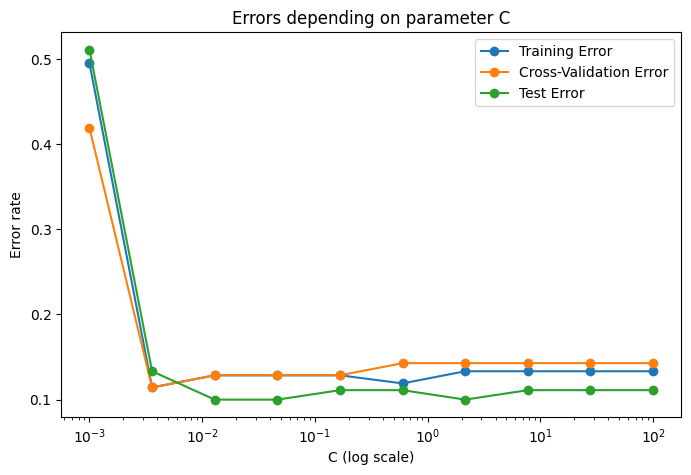

In [40]:
plt.figure(figsize=(8,5))
plt.plot(C_values, train_errors, '-o', label='Training Error')
plt.plot(C_values, cv_errors, '-o', label='Cross-Validation Error')
plt.plot(C_values, test_errors, '-o', label='Test Error')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Error rate')
plt.title('Errors depending on parameter C')
plt.legend()
plt.show()


  * Discuss your results
  
The SVM with **C = 0.0036-0.01** achieved the lowest cross-validation error (~ 0.114) and test error (~ 0.10-0.13), showing the best generalization.  
When **C = 0.001**, both errors were high (CV = 0.419, Test = 0.511), indicating **underfitting**.  
For larger values (**C ≥ 1**), the training error remained low, but the cross-validation and test errors stopped improving, suggesting **overfitting**.  

Overall, the results confirm that a **moderate C value** provides the best trade-off between bias and variance.


## Part C: Regression trees on Carseats data.

We will be using more data from the `ISLP` package. In this case, the data corresponds to children's car seats sales. More information can be found in the `README.md` file of the `data` folder. We seek to predict the values in the `Sales` column using regression trees.

### 1. **Process Data**
  You will need the `ISLP` package installed. With it, you can run `from ISLP import load_data()` to load the function that will gather the data for you.

  * Load the data using `load_data("Carseats")`
  * Split the data into a training set (70%) and a testing set (30%).


In [41]:
import pandas as pd
import numpy as np
from ISLP import load_data
import matplotlib.pyplot as plt

df=load_data('Carseats')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB


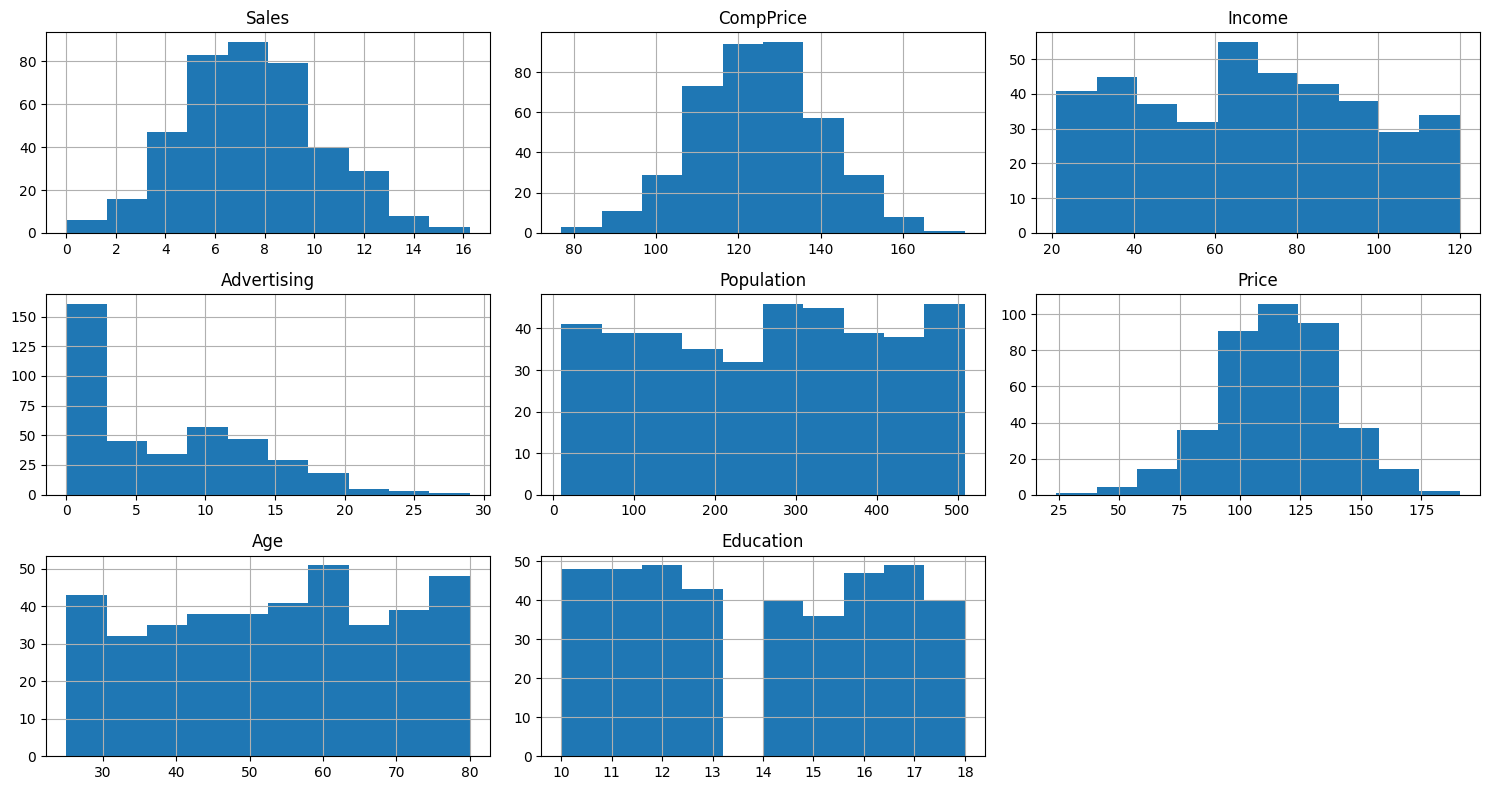

In [42]:
# Plotting numeric features
df.select_dtypes('number').hist(figsize=(15,8))
plt.tight_layout()
plt.show()

In [43]:
# Categorical features
for i in df.select_dtypes('category').columns:
    print(df[i].value_counts())
    print('-'*10)

ShelveLoc
Medium    219
Bad        96
Good       85
Name: count, dtype: int64
----------
Urban
Yes    282
No     118
Name: count, dtype: int64
----------
US
Yes    258
No     142
Name: count, dtype: int64
----------


In [44]:
# One-hot for categorical features
categorical_features=df.select_dtypes('category').columns
df=pd.get_dummies(df,columns=categorical_features,drop_first=True,dtype='int')

from sklearn.model_selection import train_test_split

# Target and feature data
Y=df['Sales']
X=df.drop(columns=['Sales'])

# Splitting data
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,
                                               random_state=159)

### 2. **Fitting the Trees**

  * Fit a regression tree to the training set. Plot the tree and interpret the results. Report the test MSE.

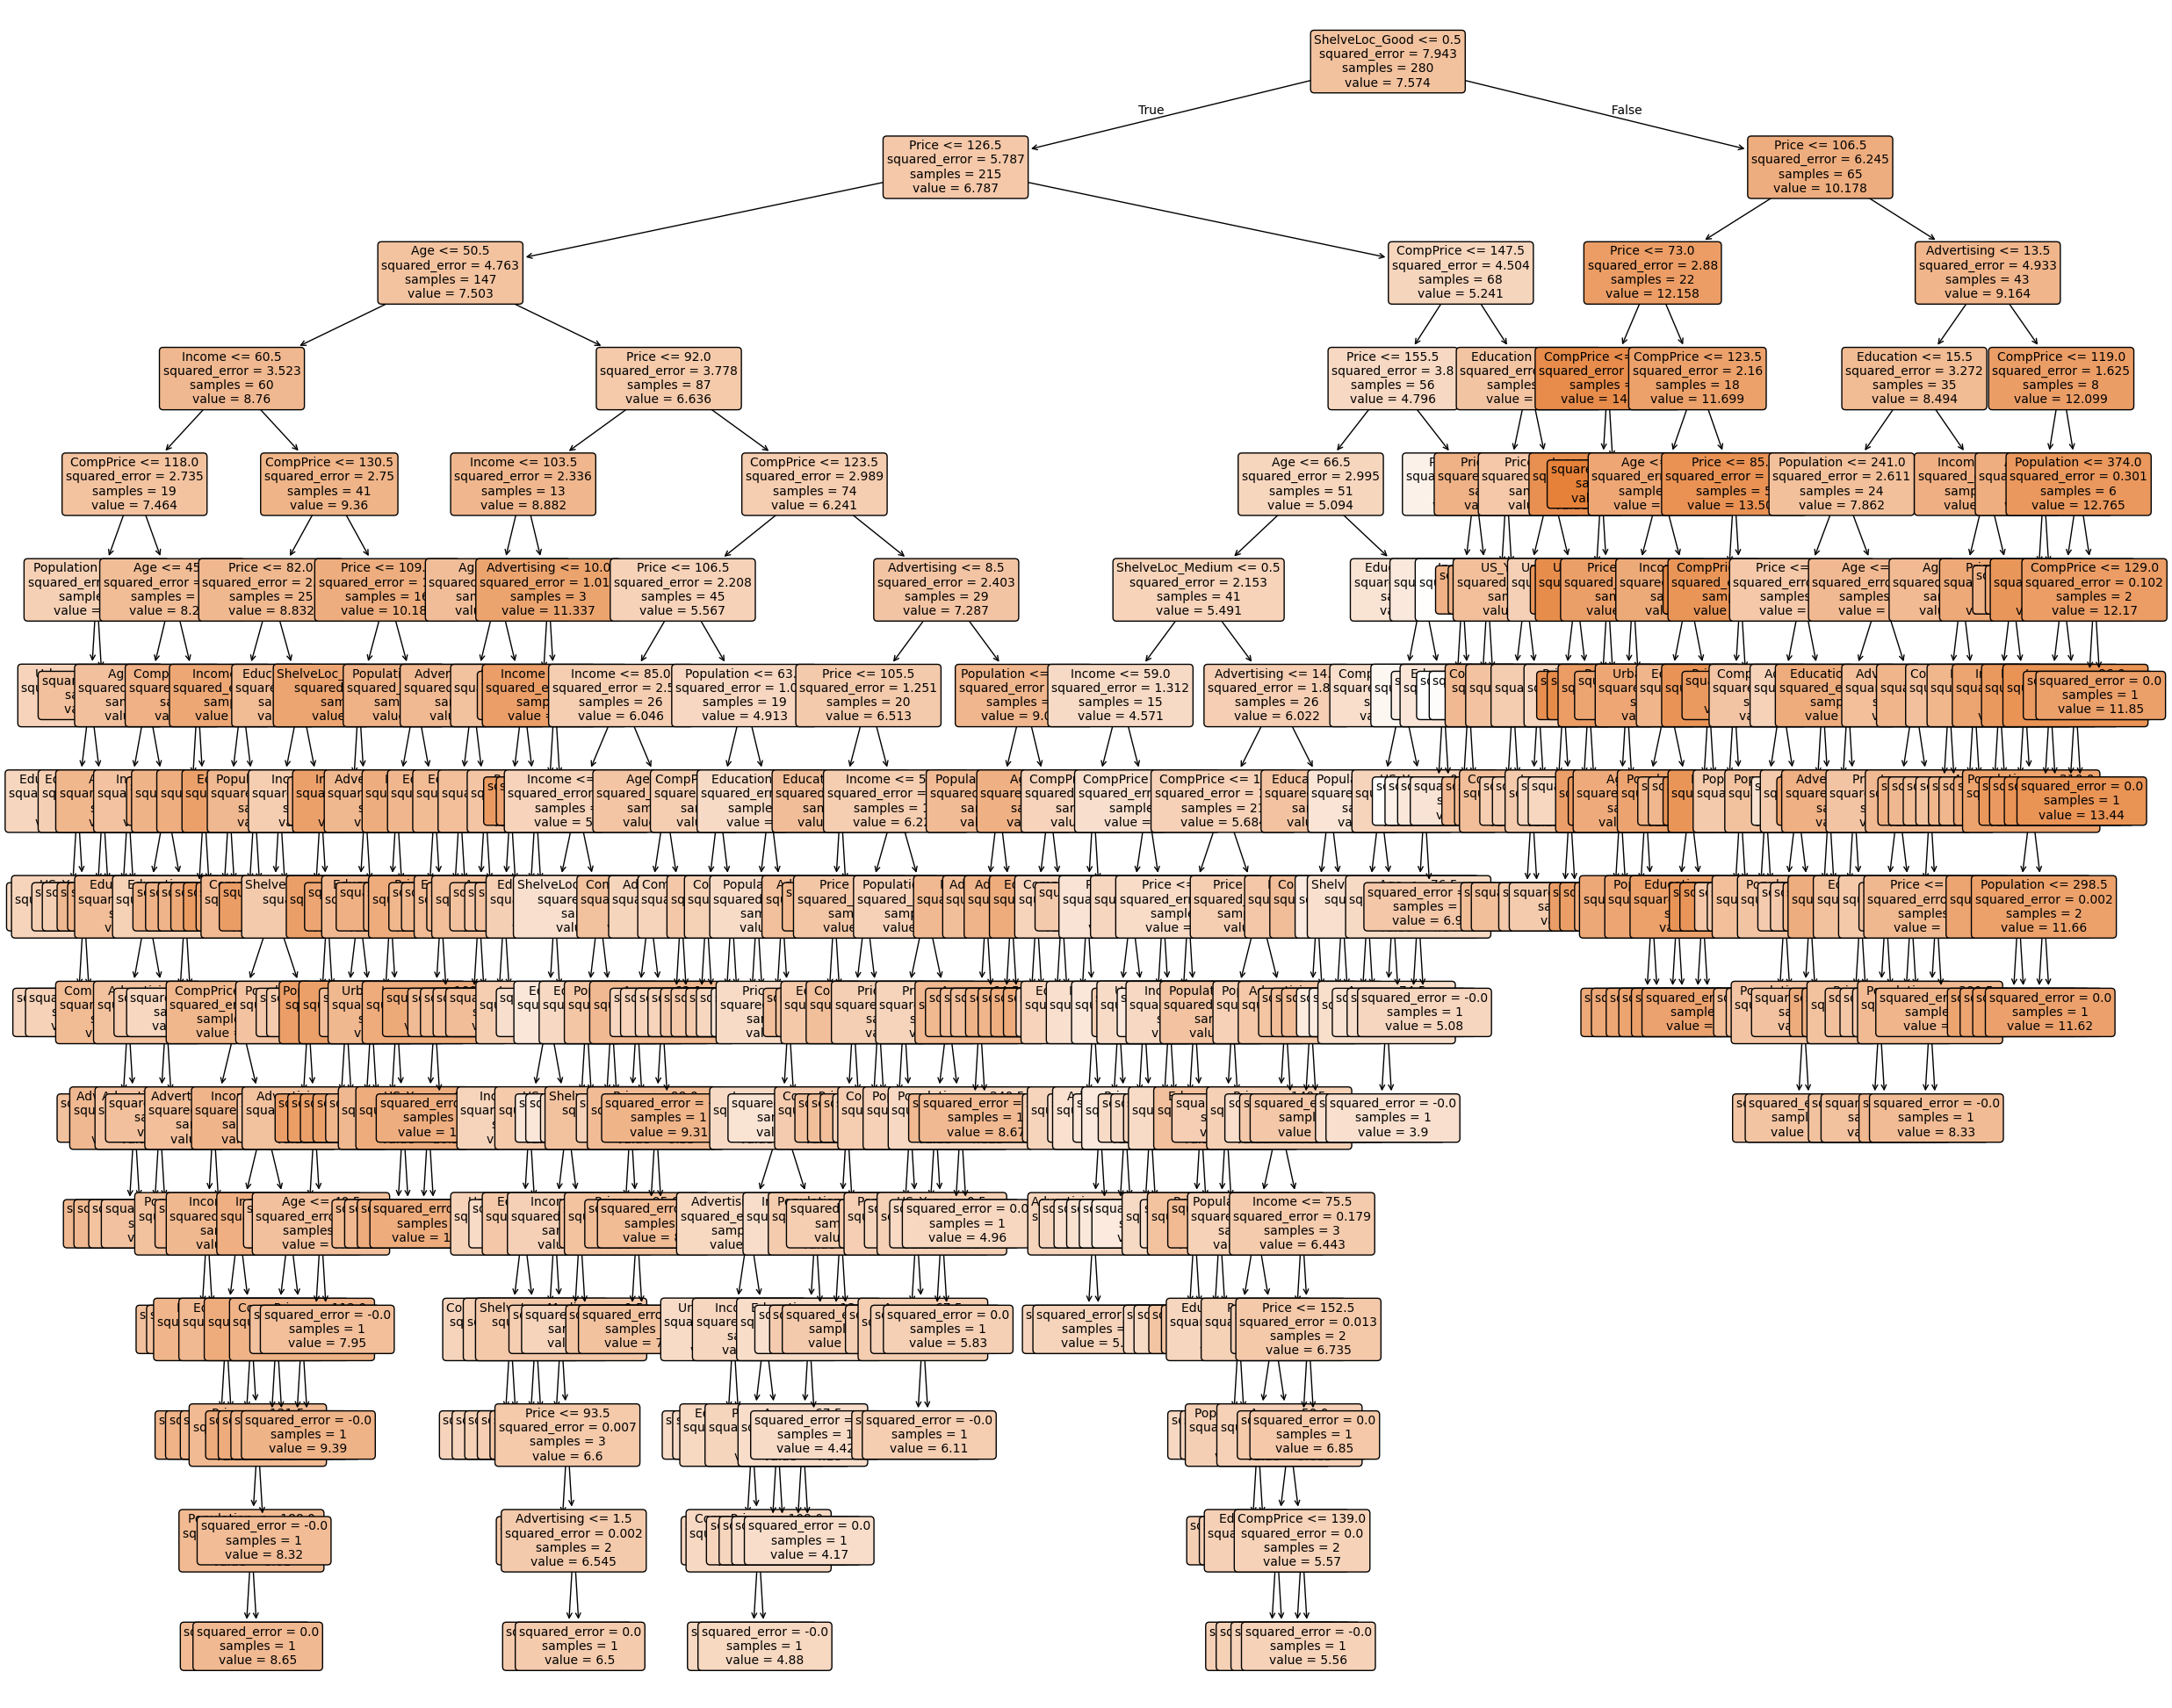

In [45]:
from sklearn.tree import DecisionTreeRegressor,plot_tree

model_tree=DecisionTreeRegressor()
model_tree.fit(x_train,y_train)

# plotting tree
plt.figure(figsize=(30,25))
plot_tree(model_tree,
          feature_names=x_train.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

>The root of the decision tree corresponds to the categorical variable indicating the quality of shelf placement (shelveloc), with two levels: good and poor.
Shelves with poor placement have an average sales of 6.7, while those with good placement have an average sales of 10.17.

>At the second level, within the left branch (poor placement), the partitioning variable is price.
Products with a price less than or equal to 126.5 have an average sales of 7.5, while those with a price greater than 126.5 have an average sales of 5.2.

>On the other hand, in the right branch (good placement), the partitioning is also performed based on price.
Products with a price less than or equal to 106.5 have an average sales of 12.15, while those with a price greater than 106.5 have an average sales of 9.16.

>and so the tree divides successively.

In [46]:
# test mean squeared error
y_pred=model_tree.predict(x_test)
mse_model_1=((y_test-y_pred)**2).mean()
print(mse_model_1)

5.306281666666666


  * Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

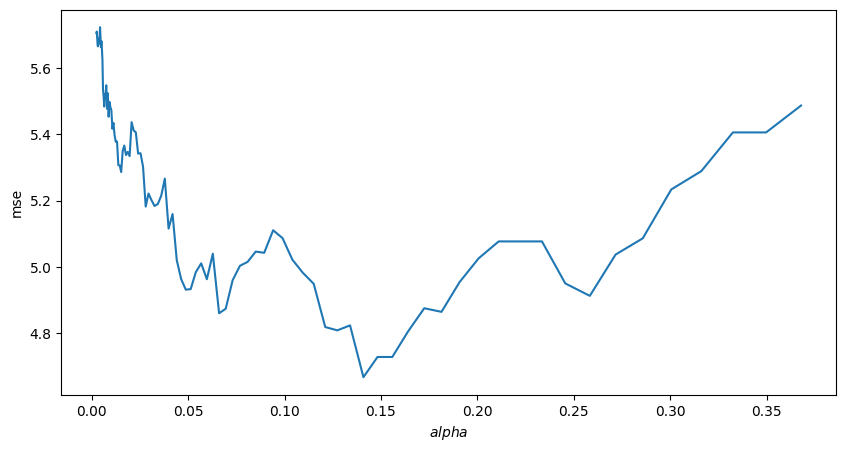

In [47]:
from sklearn.model_selection import KFold, cross_validate

alphas = np.exp(np.linspace(-6, -1, 100))
folds = KFold(5, shuffle = True, random_state = 123)
mses = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    model_tree = DecisionTreeRegressor(ccp_alpha = alpha,
                                        random_state = 123)
    results = cross_validate(model_tree, X, Y, cv = folds,
                              scoring = "neg_mean_squared_error")
    mses[i] = (results["test_score"]).mean()

# Plotting mean squared error vs alphas
_, ax = plt.subplots(figsize = (10, 5))
ax.plot(alphas, -1*mses)
ax.set_xlabel("$alpha$")
ax.set_ylabel("mse")
plt.show()

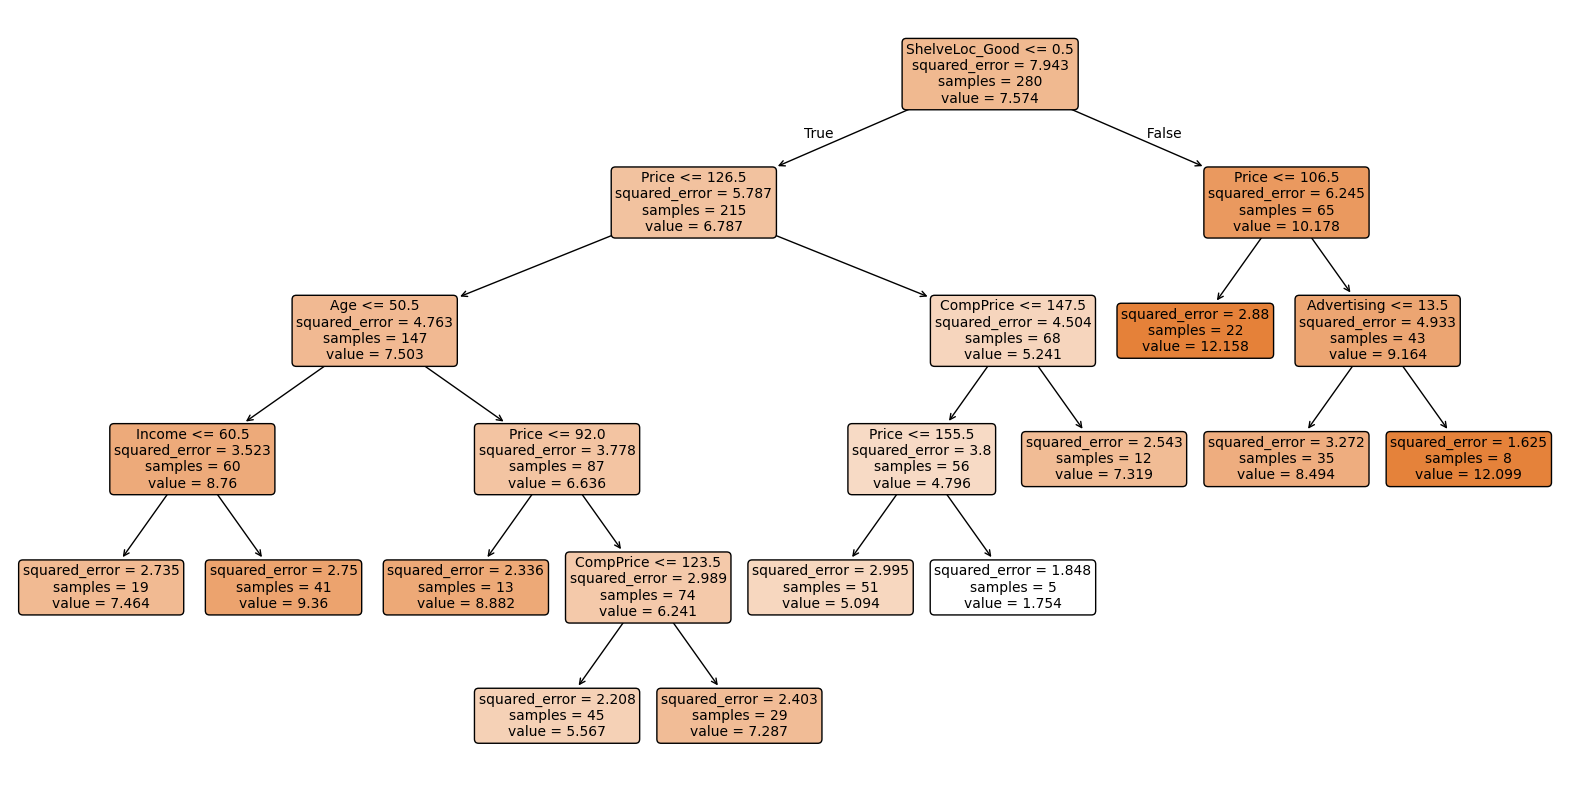

In [48]:
optimal_alpha = alphas[np.argmin(mses*(-1))]
optimal_alpha

model_tree=DecisionTreeRegressor(ccp_alpha=optimal_alpha)
model_tree.fit(x_train,y_train)

# plotting tree
plt.figure(figsize=(20,10))
plot_tree(model_tree,
          feature_names=x_train.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

In [49]:
# MSE for tree pruning
y_pred = model_tree.predict(x_test)
mse_model_2 = ((y_test - y_pred) ** 2).mean()

# Evaluation
print("MSE for tree without pruning:")
print(mse_model_1)

print("MSE for tree with pruning:")
print(mse_model_2)

print('Difference:')
print(mse_model_1-mse_model_2)

MSE for tree without pruning:
5.306281666666666
MSE for tree with pruning:
5.0586506886644775
Difference:
0.24763097800218858


>The second model with the pruned tree has 0.23 less mean square error on the test data, indicating a small improvement in the generalization of our regression tree.